# Optimize a GPyTorch likelihood with scipy

Let's do a head-to-head comparison of a GPyTorch likelihood function against a celerite likelihood function.

In [1]:
import gpytorch
import celerite
import torch
import multiprocessing
ncpus = multiprocessing.cpu_count()

In [2]:
gpytorch.__version__, celerite.__version__, torch.__version__, ncpus

('0.3.6', '0.3.1', '1.3.0', 8)

We'll need some other standard and astronomy-specific imports and configurations.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Generate a draw from a GP with known properties.

In [4]:
from celerite import terms

In [5]:
true_rho = 0.7
true_sigma = 3.2
true_white_noise = 0.3

In [6]:
true_log_sigma = np.log(true_sigma)
true_log_rho = np.log(true_rho)  # Has units of time, so 1/f

In [7]:
kernel_matern = terms.Matern32Term(log_sigma=true_log_sigma, log_rho=true_log_rho, eps=0.000001)

In [8]:
t_vec = np.linspace(0, 40, 500)

In [9]:
gp = celerite.GP(kernel_matern, mean=0, fit_mean=False)
gp.compute(t_vec)
y_true = gp.sample()

In [10]:
noise = np.random.normal(0, true_white_noise, size=len(y_true))
y_obs = y_true + noise

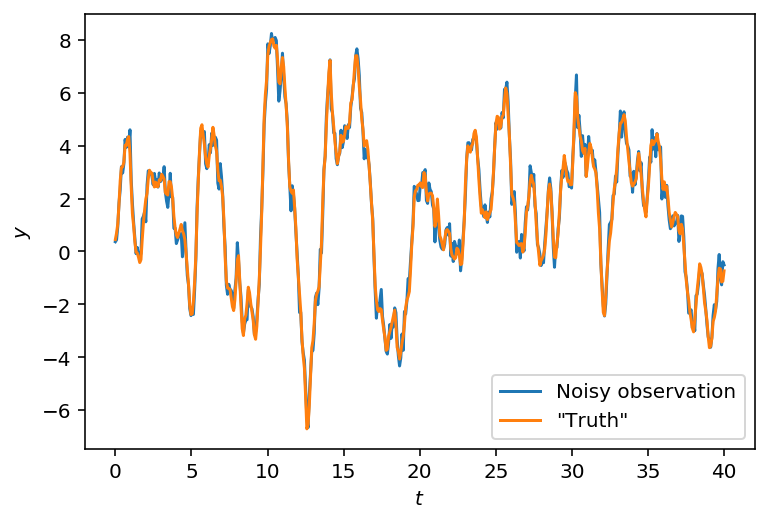

In [11]:
plt.plot(t_vec, y_obs, label='Noisy observation')
plt.plot(t_vec, y_true, label='"Truth"')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend();

Ok, we have a dataset to work with.

## Benchmark: retrieve parameters with celerité 

We either need to tell celerité what noise level to expect, or fit for it.

In [12]:
known_noise = True

In [13]:
if known_noise:
    gp.compute(t_vec, yerr=true_white_noise)
else:
    jit_kernel = terms.JitterTerm(log_sigma=np.log(true_white_noise))
    net_kernel = jit_kernel + kernel_matern
    gp = celerite.GP(net_kernel, mean=0, fit_mean=False)
    gp.compute(t_vec) #populate with near-zero values

In [14]:
gp.get_parameter_dict()

OrderedDict([('kernel:log_sigma', 1.1631508098056809),
             ('kernel:log_rho', -0.35667494393873245)])

In [15]:
print("Initial log-likelihood: {0}".format(gp.log_likelihood(y_obs)))

Initial log-likelihood: -496.70754880445213


That's the log-likelihood for the *True* values.  What if we assign incorrect values?

In [16]:
initial_params = np.array([np.log(5), np.log(0.5)])
gp.set_parameter_vector(initial_params)
bad_draw = gp.sample()

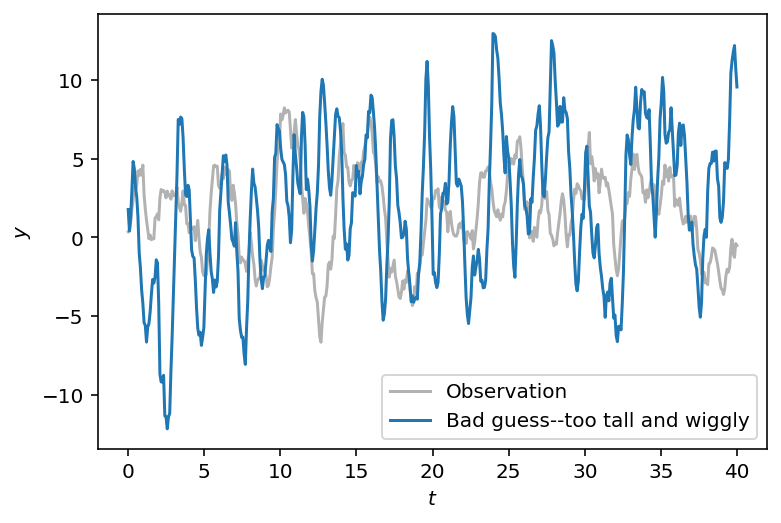

In [17]:
plt.plot(t_vec, y_obs, 'k-', label='Observation', alpha=0.3)
plt.plot(t_vec, bad_draw, label='Bad guess--too tall and wiggly')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend();

In [18]:
print("Initial log-likelihood: {0}".format(gp.log_likelihood(y_obs)))

Initial log-likelihood: -604.1622287977199


The new parameters have much lower likelihood than the True ones-- no surprise!  Here's the key part:

In [19]:
def neg_log_like(params, y, gp1):
    gp1.set_parameter_vector(params)
    return -gp1.log_likelihood(y)

def grad_neg_log_like(params, y, gp1):
    gp1.set_parameter_vector(params)
    return -gp1.grad_log_likelihood(y)[1]

In [20]:
from scipy.optimize import minimize

In [21]:
%%time
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=None, args=(y_obs, gp))

CPU times: user 51.1 ms, sys: 3.64 ms, total: 54.7 ms
Wall time: 52.4 ms


In [22]:
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

Final log-likelihood: -496.13637712331126


Let's visualize the likelihood contour:

In [23]:
rhos  = np.linspace(0.2, 1, 50)
sigmas = np.linspace(0.2, 6, 60)

In [24]:
likelihood_grid = np.zeros((50,60))

In [25]:
%%time
for i, rho in enumerate(rhos):
    for j, sigma in enumerate(sigmas):
        gp.set_parameter_vector(np.array([np.log(sigma), np.log(rho)]))
        likelihood_grid[i,j] = gp.log_likelihood(y_obs)

CPU times: user 603 ms, sys: 8.66 ms, total: 612 ms
Wall time: 614 ms


extent : scalars (left, right, bottom, top), optional

In [26]:
extents = [sigmas.min(), sigmas.max(), rhos.min(), rhos.max()]
best_fit = np.exp(soln.x)
init_par = np.exp(initial_params)

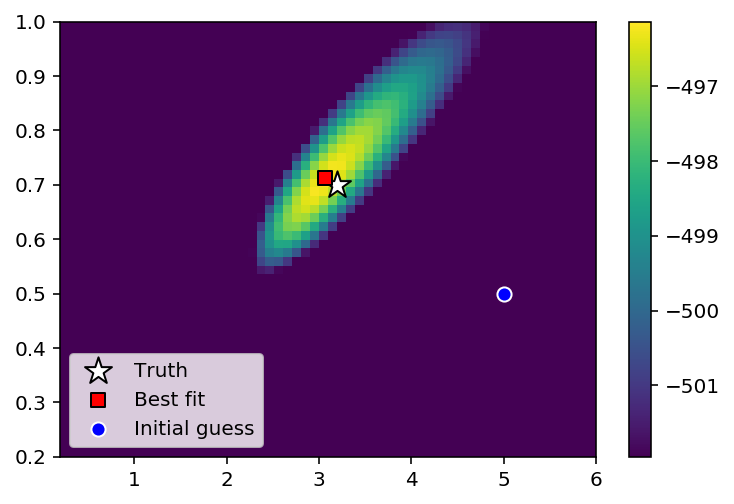

In [27]:
plt.imshow(likelihood_grid, origin='lower', extent=extents, 
           vmax=likelihood_grid.max(), 
           vmin=likelihood_grid.max()+np.log(0.003),
           aspect='auto')
cb = plt.colorbar()
plt.scatter([true_sigma], [true_rho], color='w', marker='*', s=200, label='Truth', ec='k')
plt.scatter([best_fit[0]], [best_fit[1]], color='r', marker='s', s=50, label='Best fit', ec='k')
plt.scatter([init_par[0]], [init_par[1]], color='b', marker='o', s=50, label='Initial guess', ec='w')
plt.legend(loc='lower left');

# GPyTorch model and GP likelihood building

Basic model building in GPyTorch

In [28]:
import torch

In [29]:
y_obs.dtype

dtype('float64')

In [30]:
t_ten = torch.from_numpy(t_vec)
y_ten = torch.from_numpy(y_obs)

train_x = t_ten.to(torch.float64)
train_y = y_ten.to(torch.float64)

We want to turn off all of the GPyTorch settings that make approximations.

In [31]:
gpytorch.settings.skip_logdet_forward(state=False)
gpytorch.settings.skip_posterior_variances(state=False)
gpytorch.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=False)
gpytorch.settings.lazily_evaluate_kernels(state=False)

In [32]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=3/2))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
with gpytorch.settings.fast_computations.log_prob(False):
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones_like(train_y)*true_white_noise**2)
    model = ExactGPModel(train_x, train_y, likelihood)

In [33]:
model.train()
likelihood.train();

#### Make the **marginal log likelihood**.

The GPyTorch default is to skip log determinant calculations, since most of the optimization power comes from gradients, which can apparently avoid the determinant call all together.  
We need to explicitly tell GPyTorch **not** to skip the logdet calculation, since we want to compare GPyTorch head-to-head with celerite.

In [34]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

#### Initialize

In [35]:
model.covar_module.outputscale = torch.tensor(true_sigma)
model.covar_module.base_kernel.lengthscale= torch.tensor([[true_rho]])

In [36]:
mvn_output = model(train_x)

In [37]:
from torch.distributions import MultivariateNormal

mvn_super = MultivariateNormal(likelihood(mvn_output).loc, 
                              covariance_matrix=likelihood(mvn_output).covariance_matrix)

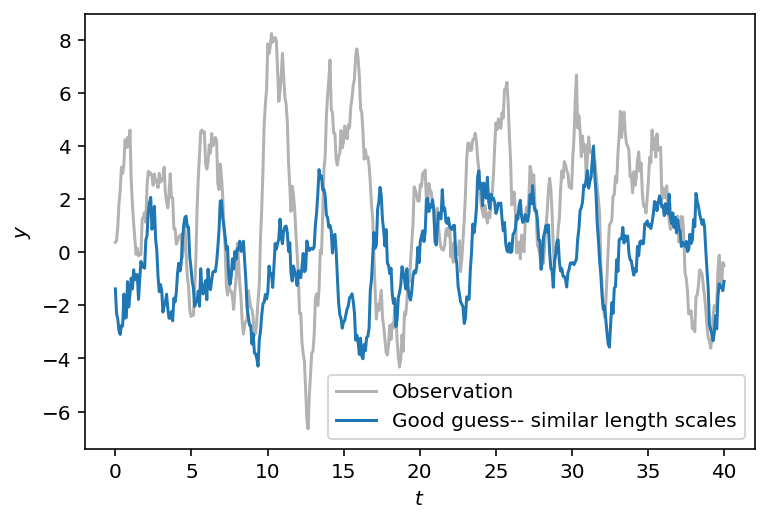

In [38]:
plt.plot(t_vec, y_obs, 'k-', label='Observation', alpha=0.3)
plt.plot(t_vec, mvn_super.sample(), label='Good guess-- similar length scales')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend();

In [39]:
def neg_log_like_torch(params):
    model.covar_module.outputscale = torch.tensor(params[0]**2)
    model.covar_module.base_kernel.lengthscale= torch.tensor([[params[1]]])
    mvn_output = model(train_x)
    with gpytorch.settings.fast_computations.log_prob(False) as W, \
         gpytorch.settings.skip_logdet_forward(state=False) as X, \
         gpytorch.settings.skip_posterior_variances(state=False) as Y, \
         gpytorch.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=False) as Z:
        neg_lnlike = -mll(mvn_output, train_y)*len(train_y)
    return neg_lnlike.detach().numpy().item()

def grad_neg_log_like_torch(params):
    model.covar_module.outputscale = torch.tensor(params[0]**2)
    model.covar_module.base_kernel.lengthscale= torch.tensor([[params[1]]])
    model.zero_grad()
    mvn_output = model(train_x)
    with gpytorch.settings.fast_computations.log_prob(False) as W, \
         gpytorch.settings.skip_logdet_forward(state=False) as X, \
         gpytorch.settings.skip_posterior_variances(state=False) as Y, \
         gpytorch.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=False) as Z:
        neg_lnlike = -mll(mvn_output, train_y)*len(train_y)
    neg_lnlike.backward()
    output = np.hstack((model.covar_module.raw_outputscale.grad.numpy(),
                        model.covar_module.base_kernel.raw_lengthscale.grad.numpy()[0]))
    return output.astype(np.float64)

In [40]:
neg_log_like([true_log_sigma, true_log_rho], y_obs, gp)

496.70754880445213

In [41]:
grad_neg_log_like([true_log_sigma, true_log_rho], y_obs, gp)

array([ 19.00809165, -20.70483599])

In [42]:
neg_log_like_torch([true_sigma, true_rho])

496.70754894327865

In [43]:
grad_neg_log_like_torch([true_white_noise, true_sigma, true_rho])

array([-3191.03735352,  2342.37939453])

Wow, we get similar results.  Not identical, but OK.  There are some weird effects from the constraints that could cause differences

In [44]:
initial_params_torch = np.array([5, 0.5])

In [45]:
%%time
soln = minimize(neg_log_like_torch, initial_params_torch, jac=grad_neg_log_like_torch,
                method="L-BFGS-B")

CPU times: user 6.09 s, sys: 213 ms, total: 6.3 s
Wall time: 989 ms


In [46]:
soln.x

array([2.90375828, 0.69783331])

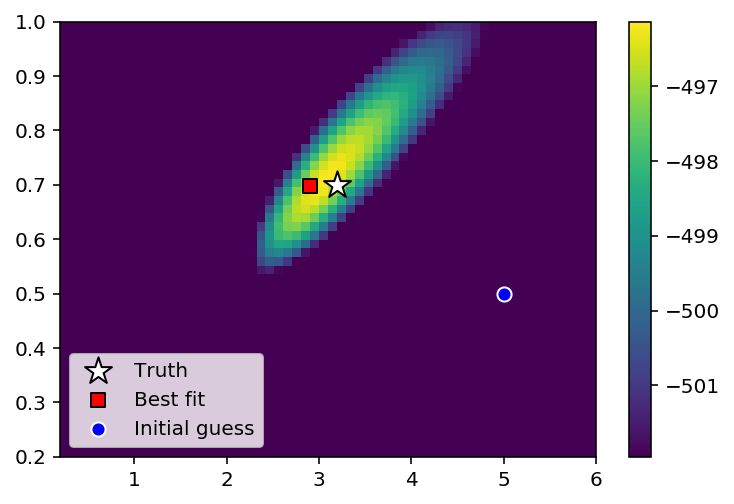

In [47]:
plt.imshow(likelihood_grid, origin='lower', extent=extents, 
           vmax=likelihood_grid.max(), 
           vmin=likelihood_grid.max()+np.log(0.003),
           aspect='auto')
cb = plt.colorbar()
plt.scatter([true_sigma], [true_rho], color='w', marker='*', s=200, label='Truth', ec='k')
plt.scatter([soln.x[0]], [soln.x[1]], color='r', marker='s', s=50, label='Best fit', ec='k')
plt.scatter([5], [0.5], color='b', marker='o', s=50, label='Initial guess', ec='w')
plt.legend(loc='lower left');

It worked!

In [48]:
likelihood_grid_torch = np.zeros((50,60))

In [49]:
%%time
for i, rho in enumerate(rhos):
    for j, sigma in enumerate(sigmas):
        likelihood_grid_torch[i,j] = -1*neg_log_like_torch([sigma, rho])

CPU times: user 1min 28s, sys: 1.47 s, total: 1min 30s
Wall time: 22.8 s


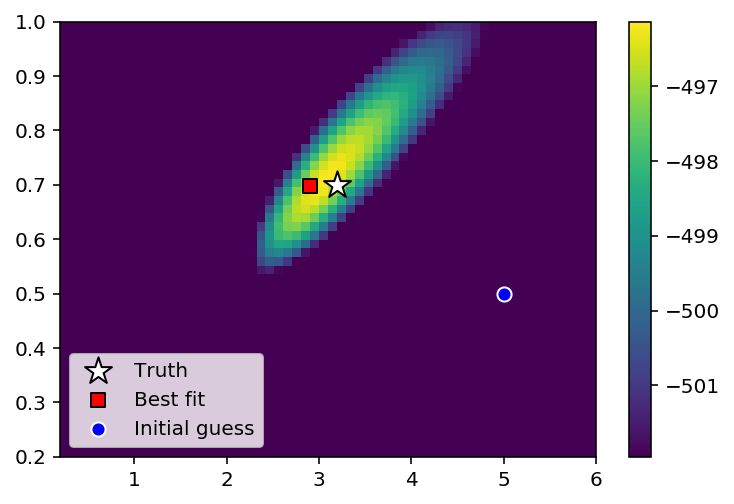

In [50]:
plt.imshow(likelihood_grid_torch, origin='lower', extent=extents, 
           vmax=likelihood_grid_torch.max(), 
           vmin=likelihood_grid_torch.max()+np.log(0.003),
           aspect='auto')
cb = plt.colorbar()
plt.scatter([true_sigma], [true_rho], color='w', marker='*', s=200, label='Truth', ec='k')
plt.scatter([soln.x[0]], [soln.x[1]], color='r', marker='s', s=50, label='Best fit', ec='k')
plt.scatter([5], [0.5], color='b', marker='o', s=50, label='Initial guess', ec='w')
plt.legend(loc='lower left');

YES! We get the same answer!!

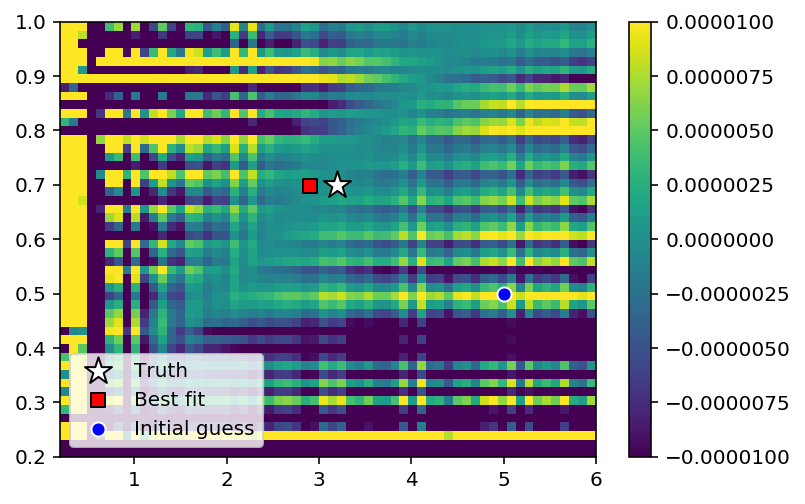

In [51]:
plt.imshow(likelihood_grid - likelihood_grid_torch, origin='lower', extent=extents, 
           vmax=-0.00001, 
           vmin=0.00001,
           aspect='auto')
cb = plt.colorbar()
plt.scatter([true_sigma], [true_rho], color='w', marker='*', s=200, label='Truth', ec='k')
plt.scatter([soln.x[0]], [soln.x[1]], color='r', marker='s', s=50, label='Best fit', ec='k')
plt.scatter([5], [0.5], color='b', marker='o', s=50, label='Initial guess', ec='w')
plt.legend(loc='lower left');

The absolute differences appear at the 0.001 level in regions of parameter space where the likelihood is extremely low.  Note that the celerite Matern kernel is technically an approximation controlled by the $\epsilon$ parameter.  Here we've assumed an epsilon of 0.01.  Lowering the epsilon to 0.0001 yields much lower residuals, pointing to celerite as the cause of the differences.